In [3]:
from qutip import *
import numpy as np
from qudpy.Classes import *
import qudpy.plot_functions as pf
import ufss  # diagram generation

Dicke model for an incoherently pumped cavity mode interacting with a set of 6 spins. The spins are defined in collective basis and the thermal cavity mode in fock basis.

In [4]:
w = 1.0  # cavity mode frequency or energy
w0 = 1.0  # spin frequency or energy
g = 1  # initial coupling strength for cavity mode-spin interaction for demonstration purposes only
gc = np.sqrt(w * w0)/2  # critical coupling strength

M = 6    # number of fock basis for cavity mode. Use larger value for stronger couplings
N = 6    # number of spins
j = N/2  # Total J for spins.
n = N+1  # dimensionality of total spin operator.

print("critical coupling strength = ", gc)

a = tensor(destroy(M), qeye(n))
Jp = tensor(qeye(M), jmat(j, '+'))
Jm = tensor(qeye(M), jmat(j, '-'))
Jz = tensor(qeye(M), jmat(j, 'z'))

H0 = w * a.dag() * a + w0 * Jz  # default basic Hamiltonian
H1 = (a + a.dag()) * (Jp + Jm)/np.sqrt(N)  # intra-cavity interaction term
H = H0 + g * H1

print("dimensionality of Hilbert-space: ", H.shape)

critical coupling strength =  0.5
dimensionality of Hilbert-space:  (42, 42)


Defining cavity mode pumping, leakage and spin dephasing.

In [5]:
n_th = 0.25  # average number thermal photons in the bath coupling to the resonator
kappa = 0.05  # cavity rate
gamma = 0.15  # spin dephasing rate
c_ops = [np.sqrt(kappa * (n_th + 1)) * a, np.sqrt(kappa * n_th) * a.dag(),np.sqrt(gamma)*Jz]

Finding steady state of system and expectation value of different operators under the influence of the system-baths couplings for different values of spin-cavity coupling

In [6]:
g_vec = np.linspace(0.01, 1, 20)  # list of different light-matter coupling strengths
rho_ss_list = [steadystate(H0 + g * H1, c_ops) for g in g_vec]  # Ground state for the Hamiltonian: H = H0 + g * H1

# calculate the expectation values
n_ss_vec = expect(a.dag() * a, rho_ss_list)  # <n> for photons
n2_ss_vec = expect(a.dag() * a*a.dag() * a, rho_ss_list)  # <n^2> for photons
Jz_ss_vec = expect(Jz, rho_ss_list)  # <Jz> for spins
a_ss_vec = expect(a, rho_ss_list)  # <a> for photons

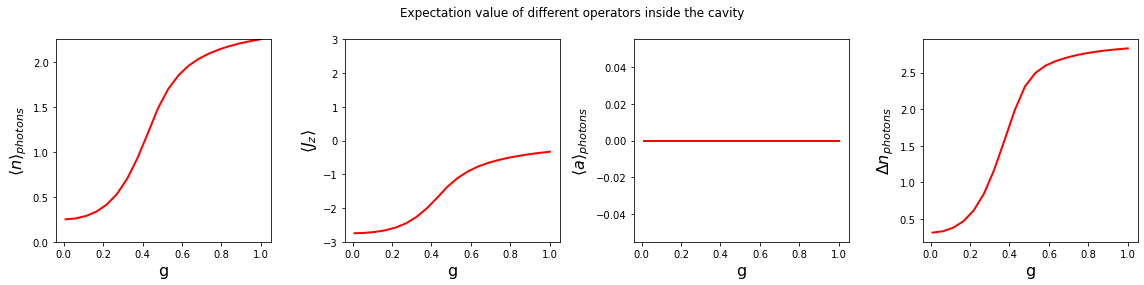

In [71]:
# Plotting the results

fig, axes = plt.subplots(1, 4, figsize=(16,4))

fig.suptitle('Expectation value of different operators inside the cavity')
axes[0].plot(g_vec, n_ss_vec, 'r', linewidth=2, label="cavity occupation")
axes[0].set_ylim(0, max(n_ss_vec))
axes[0].set_ylabel(r"$\langle n\rangle _{photons}$", fontsize=16)
axes[0].set_xlabel("g", fontsize=16)

axes[1].plot(g_vec, Jz_ss_vec, 'r', linewidth=2, label="<Jz>")
axes[1].set_ylim(-j, j)
axes[1].set_ylabel(r"$\langle J_z\rangle$", fontsize=16)
axes[1].set_xlabel("g", fontsize=16)

axes[2].plot(g_vec, abs(a_ss_vec), 'r', linewidth=2, label="<a>")
axes[2].set_ylabel(r"$\langle a \rangle _{photons}$", fontsize=16)
axes[2].set_xlabel("g", fontsize=16)

axes[3].plot(g_vec, n2_ss_vec - n_ss_vec**2, 'r', linewidth=2)
axes[3].set_ylabel(r"$\Delta n _{photons}$", fontsize=16)
axes[3].set_xlabel("g", fontsize=16)

fig.tight_layout()

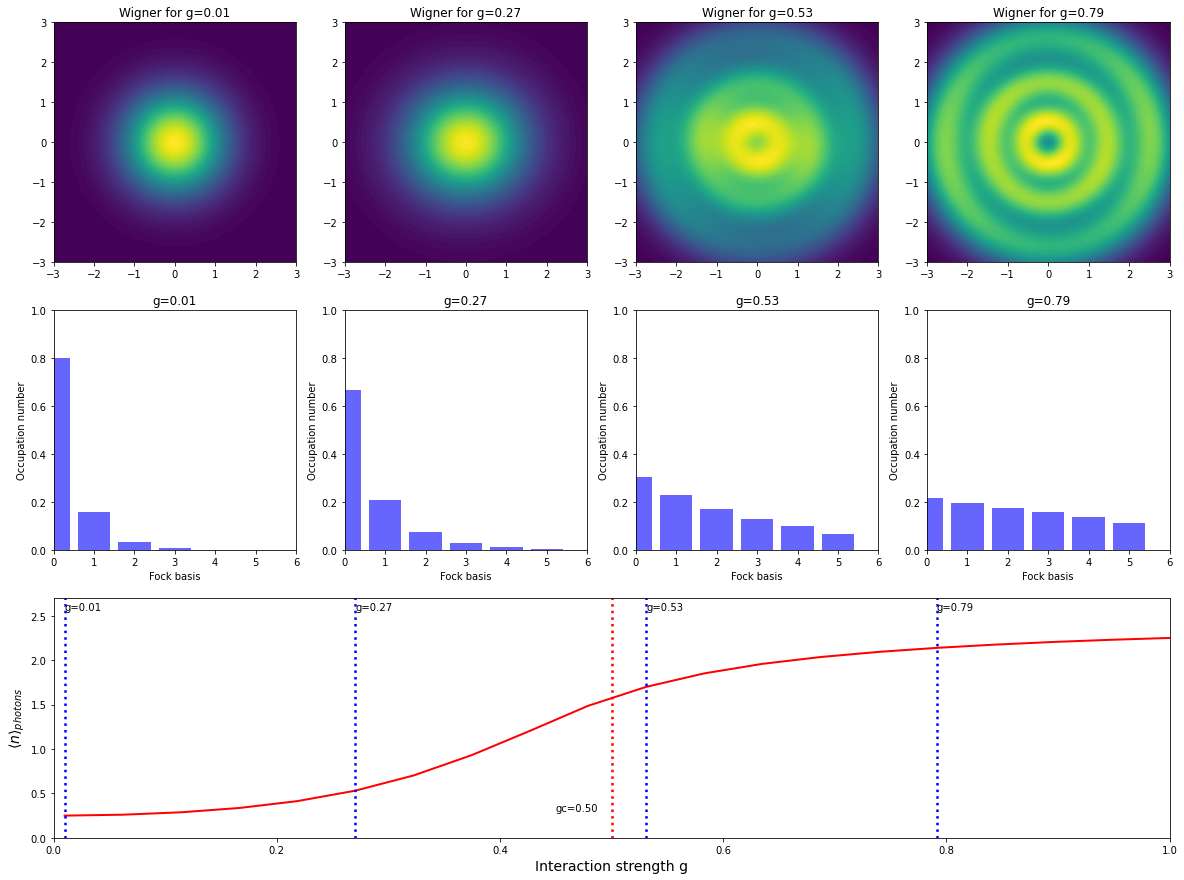

In [72]:
rho_ss_sublist = rho_ss_list[::5]  # pick density matrices from the original list each separated by 5 values (5 picked out of original 20)
g_sublist = g_vec[::5]

xvec = np.linspace(-3, 3, 200)  # grid required for plotting the wigner function for the cavity mode.

fig_grid = (3, len(rho_ss_sublist))
fig = plt.figure(figsize=(5 * len(rho_ss_sublist), 15))

for idx, rho_ss in enumerate(rho_ss_sublist):
    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)  # perform partial trance, keeping only the first subsystem i.e. cavity mode.

    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)

    # plot its wigner function
    ax = plt.subplot2grid(fig_grid, (0, idx))
    ax.contourf(xvec, xvec, W, 100)  # with 100 contour lines
    ax.set_title(f'Wigner for g={g_sublist[idx]:.2f}')
    # plot its fock-state distribution
    ax = plt.subplot2grid(fig_grid, (1, idx))
    ax.bar(np.arange(0, M), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.6)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, M)
    ax.set_title(f'g={g_sublist[idx]:.2f}')
    ax.set_ylabel("Occupation number", fontsize=10)
    ax.set_xlabel("Fock basis", fontsize=10)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (2, 0), colspan=fig_grid[1])
ax.plot(g_vec, n_ss_vec, 'r', linewidth=2)
ax.set_xlim(0, max(g_vec))
ax.set_ylim(0, max(n_ss_vec) * 1.2)
ax.set_ylabel(r"$\langle n\rangle _{photons}$", fontsize=14)
ax.set_xlabel("Interaction strength g", fontsize=14)

for g in g_vec[::5]:
    ax.plot([g, g], [0, max(n_ss_vec) * 1.2], 'b:', linewidth=2.5)
    ax.text(g, 0.95*max(n_ss_vec) * 1.2, f'g={g:.2f}')

ax.plot([gc, gc], [0, max(n_ss_vec) * 1.2], 'r:', linewidth=2.5)
ax.text(gc-0.05, 0.3, f'gc={gc:.2f}')
plt.show()

# Points to note:
if the interaction strength is below the critical coupling, the number of fock basis for cavity mode can be truncated to a smaller value, saving computational cost in the subsequent non-linear response calculations.

Taking the interaction strength to be 0.25 (i.e. 50% of the critical coupling) and reformulating the system.

In [50]:
g = 0.25  # coupling strength. For this case it is 50% of the critical coupling
H0 = w * a.dag() * a + w0 * Jz
H1 = (a + a.dag()) * (Jp + Jm)/np.sqrt(N)
H = H0 + g * H1

print("dimensionality of Hilbert-space: ",H.shape)

en,T = H.eigenstates()

Hd=H.transform(T)

# average number thermal photons in the bath coupling to the resonator
n_th = 0.25
c1 = np.sqrt(kappa * (n_th + 1)) * a
c2 = np.sqrt(kappa * n_th) * a.dag()
c3 = np.sqrt(gamma)*Jz

c1d =c1.transform(T)
c2d =c2.transform(T)
c3d =c3.transform(T)

# A and A.dag() are now the excitation/de-excitation operators due to the coupling to the external photon-field
# and we need x-form this to the eigenbasis
A = a.transform(T)

mud = A + A.dag()

print("finding steady-states of the DM")
# define density matrix as steady-state in the eigenbasis
rhoSS=steadystate(Hd, [c1d,c2d,c3d])


# properties of the SS system (need to use transformed operators )
n_ss = expect(A.dag() * A, rhoSS)
n2_ss = expect(A.dag()*A*A.dag()*A,rhoSS)

print("Steady State Properties")
print("<n> = ",n_ss)
print("<n^2> = ",n2_ss)
print("<(n-<n>)^2> = ",n2_ss-n_ss*n_ss)

# defining the system
sys2 = System(H=Hd, a=A, u=mud, c_ops=[c1d, c2d, c3d], rho=rhoSS, diagonalize=False)
sys2.hbar=1

dimensionality of Hilbert-space:  (42, 42)
finding steady-states of the DM
Steady State Properties
<n> =  0.479041532001824
<n^2> =  0.9700095797062814
<(n-<n>)^2> =  0.7405287903236268
system initialized


In [51]:
# setting up the third order response diagrams
DG = ufss.DiagramGenerator
R3rd = DG()
# setting condition for rephasing diagrams R1,2,3
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])
# Set the pulse interval
t_pulse = np.array([-1, 1])
R3rd.efield_times = [t_pulse]*4
# Creating diagrams for pulse arrival times 0, 100, 200 and detection time 300.
[R3, R1, R2] = R3rd.get_diagrams([0, 100, 200, 300])
rephasing = [R1, R2, R3]
print('the rephasing diagrams are R1, R2 and R3 ', rephasing)

# setting conditions for and generating non-rephasing diagrams R4, R5 and R6
R3rd.set_phase_discrimination([(1, 0), (0, 1), (1, 0)])
[R6, R4, R5] = R3rd.get_diagrams([0, 100, 200, 200])
nonrephasing = [R4, R5, R6]
print('the non-rephasing diagrams are R4, R5 and R6', nonrephasing)

diagrams = rephasing+nonrephasing

the rephasing diagrams are R1, R2 and R3  [(('Bu', 0), ('Ku', 1), ('Bd', 2)), (('Bu', 0), ('Bd', 1), ('Ku', 2)), (('Bu', 0), ('Ku', 1), ('Ku', 2))]
the non-rephasing diagrams are R4, R5 and R6 [(('Ku', 0), ('Bu', 1), ('Bd', 2)), (('Ku', 0), ('Kd', 1), ('Ku', 2)), (('Ku', 0), ('Bu', 1), ('Ku', 2))]


total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


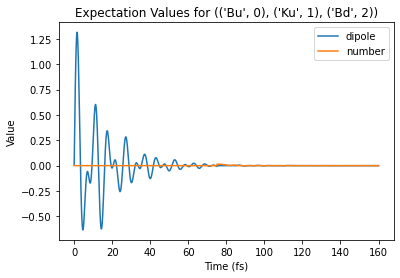

In [73]:
# performing a single evolution of R1 with a scan time of 75 fs for t1 and t3, and 10 fs for t2
states = sys2.diagram_donkey([0, 75, 85, 160], [R1], r=10)

## Generating third order response

In [ ]:
# generating 2Dcoherence response for rephasing
time_delays = [100, 10, 100]
scan_id = [0, 2]
response_list = []
states_list = []
for k in range(6):
    states, t1, t2, dipole = sys2.coherence2d(time_delays, diagrams[k], scan_id, r=1/2, parallel=True)
    print('diagram ', k, ' done')
    response_list.append(1j*dipole)
    states_list.append(states)

In [ ]:
# you can save these files in your desired directory
qsave(response_list, 'dipole_xyz')
qsave(states_list, 'states_xyz')

In [57]:
# loading computed results
response_list  = qload('/home/shah/PycharmProjects/QuDPy/examples/results/example2/dipole_6spin_6cavity_res_half_range_100_10_100')

In [59]:
# computing and plotting the spectra
spectra_list, extent, f1, f2 = sys2.spectra(np.imag(response_list), resolution=1/2)

In [66]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [70]:
%matplotlib inline

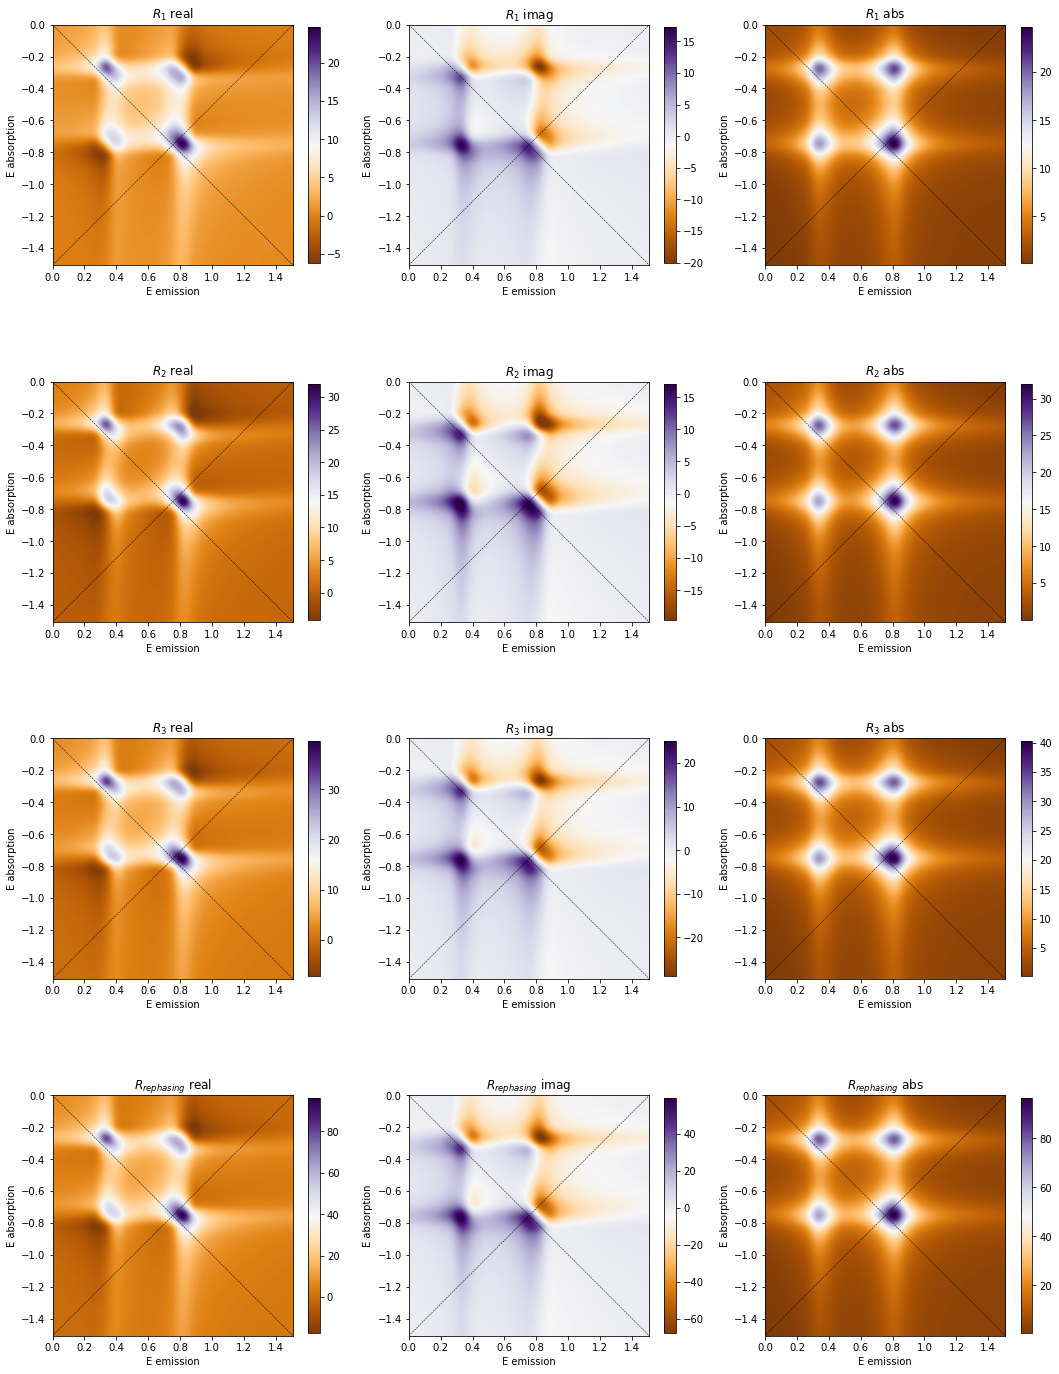

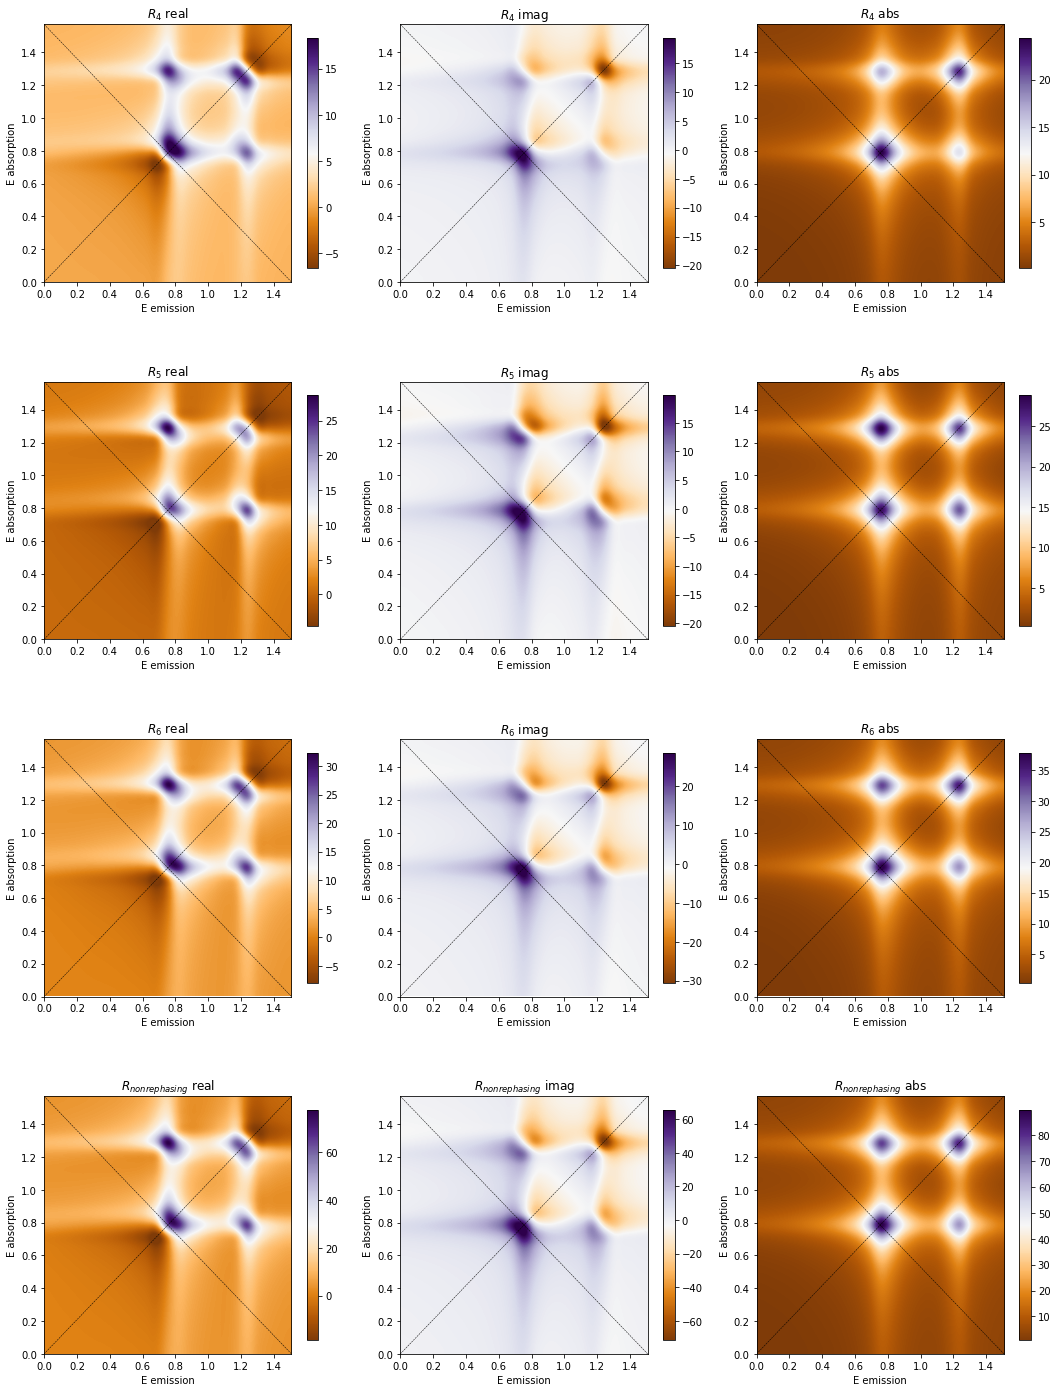

In [65]:
rephasing_spectra = spectra_list[:3]
rephasing_spectra.append(np.sum(spectra_list[:3], 0))
pf.silva_plot(rephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_1$', '$R_2$', '$R_3$', '$R_{rephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='4', invert_y=False,
              diagonals=[True, True])

nonrephasing_spectra = spectra_list[3:]
nonrephasing_spectra.append(np.sum(spectra_list[3:], 0))
pf.silva_plot(nonrephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_4$', '$R_5$', '$R_6$', '$R_{nonrephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='1', invert_y=False,
              diagonals=[True, True])

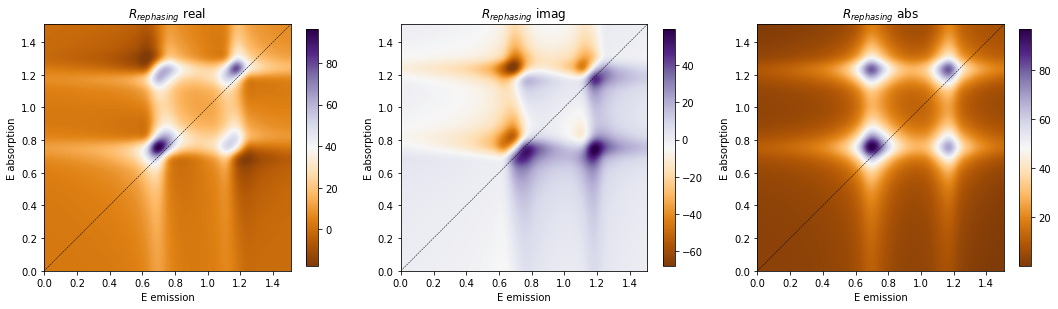

In [83]:
rephasing_spectra = spectra_list[:3]
rephasing_spectra.append(np.sum(spectra_list[:3], 0))
pf.silva_plot([rephasing_spectra[-1]], scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_{rephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='4', invert_y=True,
              diagonals=[False, True])

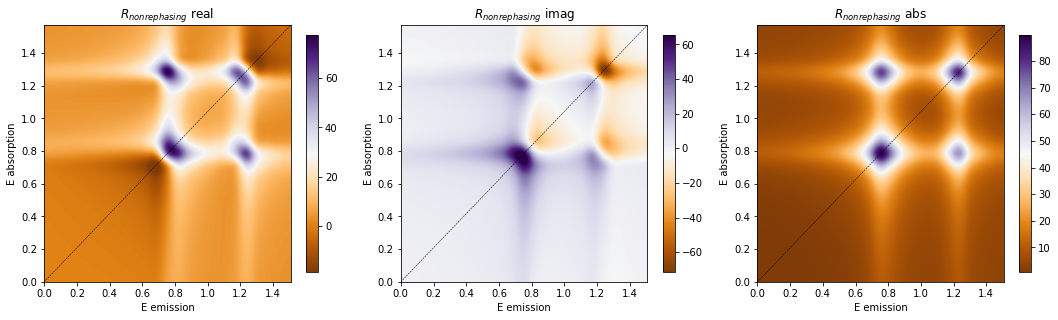

In [84]:
nonrephasing_spectra = spectra_list[3:]
nonrephasing_spectra.append(np.sum(spectra_list[3:], 0))
pf.silva_plot([nonrephasing_spectra[-1]], scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_{nonrephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='1', invert_y=False,
              diagonals=[False, True])